In [2]:
from numpy import polyfit
from astropy.utils.data import download_file
from astropy.utils.data import Conf 
Conf.remote_timeout = 10
import warnings
warnings.filterwarnings('ignore')
%pylab
%matplotlib inline
from cosmoslik import get_plugin, param, SlikPlugin, SlikDict, run_chain
from cosmoslik.utils import load_chain
rc('text', usetex = True)
import pandas as pd
#from progress.bar import Bar

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
class Hubble_Chain(SlikDict):
    def __init__(self, quad = True, cubic = False, numsamples = 50000):
        #self.bar = Bar('Samples', max = numsamples)
        
        self.cepheids, self.sne = get_data()
        self.cepheids = self.cepheids.loc[self.cepheids.Flag == '-',:]

        self.fields = set(self.cepheids.Field)
        self.params = SlikDict()
        self.numsamples = numsamples
        for name in set(self.cepheids.Field):
            self.params[('\delta\mu_p_'+name)] = param(start = 2.5, scale = .04)
        self.params['\delta\mu_p_n4258'] = 0
        self.params['z_pn4258'] = param(start = 26.27, scale = 0.08)
        self.params.b = param(start = -2.98, scale = .06)
        self.params.Z = param(start = -0.240, scale = .09)
        self.params.color_bias = 0#param(start = 0 , scale = 0.04, gaussian_prior= (0,1))
        self.params.SN_mag_4258 = param(start = 10.25, scale = .05)
        self.params.geo_dist = param(start = 7.6, scale  = 0.32, gaussian_prior = (7.6, 0.32))
        self.params['a_nu'] = param(start = 0.698,scale = 0.00225, gaussian_prior = (0.698,0.00225))      
        
        self.sampler = get_plugin('samplers.metropolis_hastings')(self,
                                                                  num_samples=self.numsamples,
                                                                  proposal_scale = 1,
                                                                  print_level = 1,  
                                                                  output_file = 'chain.chain',
                                                                 proposal_cov = 'proposal.covmat',
                                                                 proposal_update = True,
                                                                 output_extra_params=['params.H0']
                                                                 )

        self.priors = get_plugin('likelihoods.priors')(self)
        
        
        
        
    def ceph_mag(self, cepheids, **params):
        
        cepheids.loc[:,'FittedMag'] = (params['z_pn4258'] 
                        + params['b'] * log10(cepheids.Period) 
                        + params['Z'] * (cepheids.ObyH - mean(cepheids.ObyH))##8.9)#mean(cepheids.loc[cepheids.Field == 'n4258', 'ObyH'])) 
                        + 0.410 * cepheids.VtoI
                       )
        for field in (self.fields):
            cepheids.loc[cepheids.Field == field,'FittedMag'] = (cepheids.loc[cepheids.Field == field, 'FittedMag'] 
                                                                 + params['\delta\mu_p_'+field]
                                                                )
        return cepheids.FittedMag.values
    
    def sne_mag(self,sne,**params):

        sne.loc[:, 'FittedMag'] = params['SN_mag_4258']
        for field in self.fields:
            sne.loc[sne.Host == field, 'FittedMag'] += params['\delta\mu_p_'+field]

        return sne.FittedMag.values
    
    
    def __call__(self):
        self.params['\mu_geometric'] = 5 * log10(self.params.geo_dist) + 25
        self.params.H0 = 10**((self.params.SN_mag_4258 - 
                               self.params['\mu_geometric'] 
                               + 5 * self.params['a_nu'] + 25.0)
                              /5.0)
        cephlnl = sum((self.cepheids.F160Wmag - self.ceph_mag(self.cepheids, **self.params))**2/self.cepheids.e_F160Wmag**2)
        #cephlnl = sum((log10(self.cepheids.period) - self.fitted_ceph_period()[0])**2/self.fitted_ceph_period()[1]**2)
        snelnl = sum((self.sne.m0_viPlus5a_v - 5 * self.params['a_nu'] - self.sne_mag(self.sne, **self.params))**2/self.sne.sigma**2)
        priors = sum(self.priors(self))
        #self.bar.next()
        return priors + (cephlnl + snelnl)
        
    
def get_data():
    cepheid_table = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t2_mrt.txt', 
        cache = True)
    cepheids = pd.read_csv(cepheid_table,
                       delim_whitespace = True,
                       skiprows = 39,
                       names = (['Field', 'RAdeg', 
                                 'DEdeg', 'ID', 
                                 'Period', 'VtoI', 
                                 'F160Wmag', 'e_F160Wmag',
                                 'Offset', 'Bias', 
                                 'IMrms', 'ObyH', 'Flag']
                               )
                      )

    cepheids=cepheids.fillna(value = '-')
    ### SNe table
    Sne_table = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t3_ascii.txt',
        cache = True)
    Sne = pd.read_csv(Sne_table, 
                   
                  delim_whitespace=True, 
                  skiprows = [0,1,2,3,4,13,15],
                  names = (['Host', 'junk','Sn1A',
                            'Filters', 'm0_viPlus5a_v',
                            'sigma', 'DeltaMu_0','e_DeltaMu_0',
                            'mu_0_Best', 'e_mu_0_Best'
                          ])
                 )
    Sne.loc[:,'e_DeltaMu_0'] = (Sne.loc[:,'e_DeltaMu_0'].apply(str).str.replace('\(|\)','')).astype('float')
    Sne.loc[:,'e_mu_0_Best'] = (Sne.loc[:,'e_mu_0_Best'].apply(str).str.replace('\(|\)','')).astype('float')
    
    return cepheids, Sne

In [ ]:
std_chain = run_chain(Hubble_Chain, kwargs ={'quad':False, 'numsamples': 30000}).burnin(0)
print std_chain.acceptance()
x =  zip(std_chain.params(),std_chain.mean(),std_chain.std())
for i in x:
    print i

Starting MCMC chain...


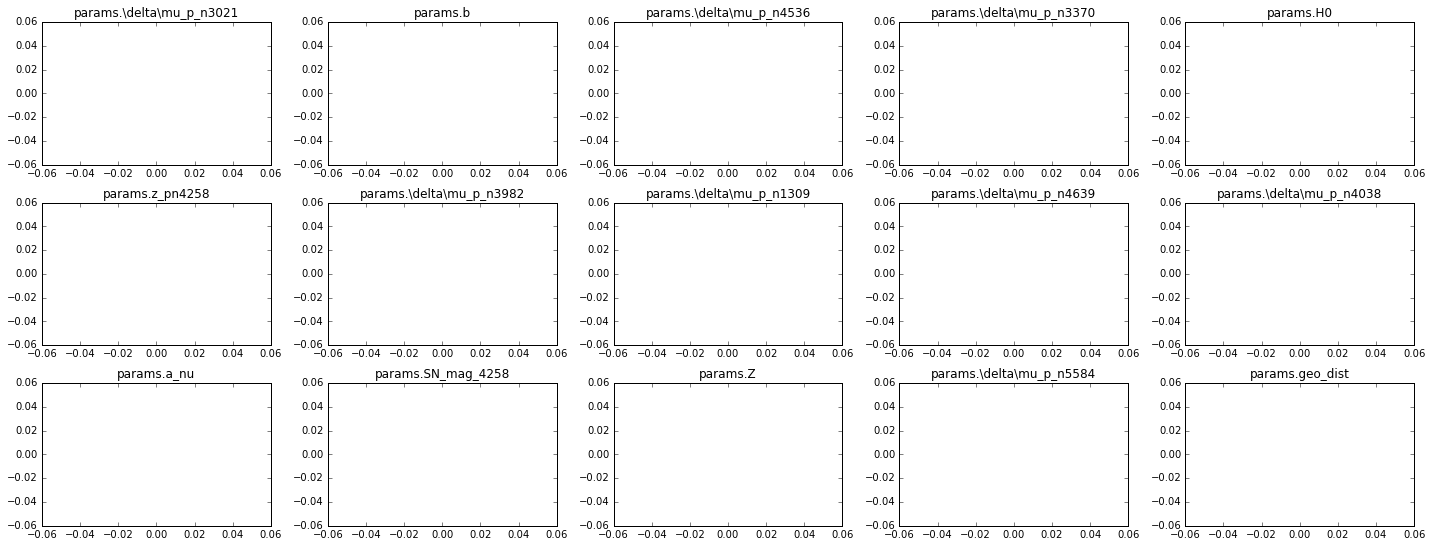

In [3]:
std_chain = load_chain('chain.chain').burnin(2000).join()
rc('text', usetex = False)
std_chain.plot()
std_chain.savecov('proposal.covmat')

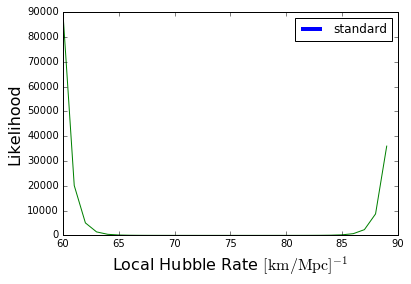

In [4]:
std_chain.like1d('params.H0', linewidth = 4, label = 'standard', nbins = 25)
legend()
#cubic_chain.like1d('params.H0', color = 'r', linewidth = 4)
ylabel('Likelihood', fontsize = 16)
xlabel(r'Local Hubble Rate $[{\rm km/Mpc}]^{-1}$', fontsize = 16)
plot(arange(60, 90), exp((arange(60, 90) - 74.8)**2/2/3.1**2))


In [70]:
x =  zip(std_chain.params(),std_chain.mean(),std_chain.std())
for i in x:
    print '%s: \t %3.4f \pm %3.4f (no quadratic term)'%i

params.\delta\mu_p_n3021: 	 2.8738 \pm 0.0528 (no quadratic term)
params.b: 	 -2.9623 \pm 0.0441 (no quadratic term)
params.\delta\mu_p_n4536: 	 1.5527 \pm 0.0307 (no quadratic term)
params.\delta\mu_p_n3370: 	 2.7195 \pm 0.0330 (no quadratic term)
params.H0: 	 73.7628 \pm 3.3664 (no quadratic term)
params.z_pn4258: 	 26.2534 \pm 0.0639 (no quadratic term)
params.\delta\mu_p_n3982: 	 2.3154 \pm 0.0418 (no quadratic term)
params.\delta\mu_p_n1309: 	 3.1284 \pm 0.0406 (no quadratic term)
params.\delta\mu_p_n4639: 	 2.2789 \pm 0.0427 (no quadratic term)
params.\delta\mu_p_n4038: 	 2.2238 \pm 0.0474 (no quadratic term)
params.a_nu: 	 0.6982 \pm 0.0022 (no quadratic term)
params.SN_mag_4258: 	 10.2445 \pm 0.0408 (no quadratic term)
params.Z: 	 -0.2452 \pm 0.0648 (no quadratic term)
params.\delta\mu_p_n5584: 	 2.3135 \pm 0.0319 (no quadratic term)
params.geo_dist: 	 7.5880 \pm 0.3104 (no quadratic term)


In [58]:
std_chain.best_fit()['lnl']

441.71266943773537

In [59]:
std_chain.best_fit()['params.H0']

75.560492758510904

In [60]:
std_chain.std()

array([  5.27941341e-02,   4.42065802e-02,   3.08110879e-02,
         3.29528196e-02,   3.38602359e+00,   6.40931894e-02,
         4.17163678e-02,   4.06661962e-02,   4.30226852e-02,
         4.74705988e-02,   2.25311595e-03,   4.08406914e-02,
         6.51420489e-02,   3.18046867e-02,   3.12443951e-01])

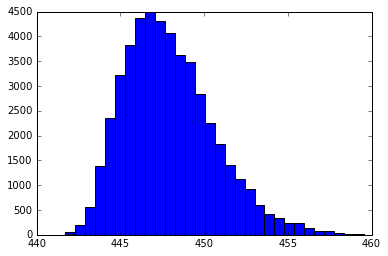

In [61]:
hist(std_chain['lnl'], weights = std_chain['weight'], bins = 30);

In [62]:
std_chain.params()

{'params.H0',
 'params.SN_mag_4258',
 'params.Z',
 'params.\\delta\\mu_p_n1309',
 'params.\\delta\\mu_p_n3021',
 'params.\\delta\\mu_p_n3370',
 'params.\\delta\\mu_p_n3982',
 'params.\\delta\\mu_p_n4038',
 'params.\\delta\\mu_p_n4536',
 'params.\\delta\\mu_p_n4639',
 'params.\\delta\\mu_p_n5584',
 'params.a_nu',
 'params.b',
 'params.geo_dist',
 'params.z_pn4258'}

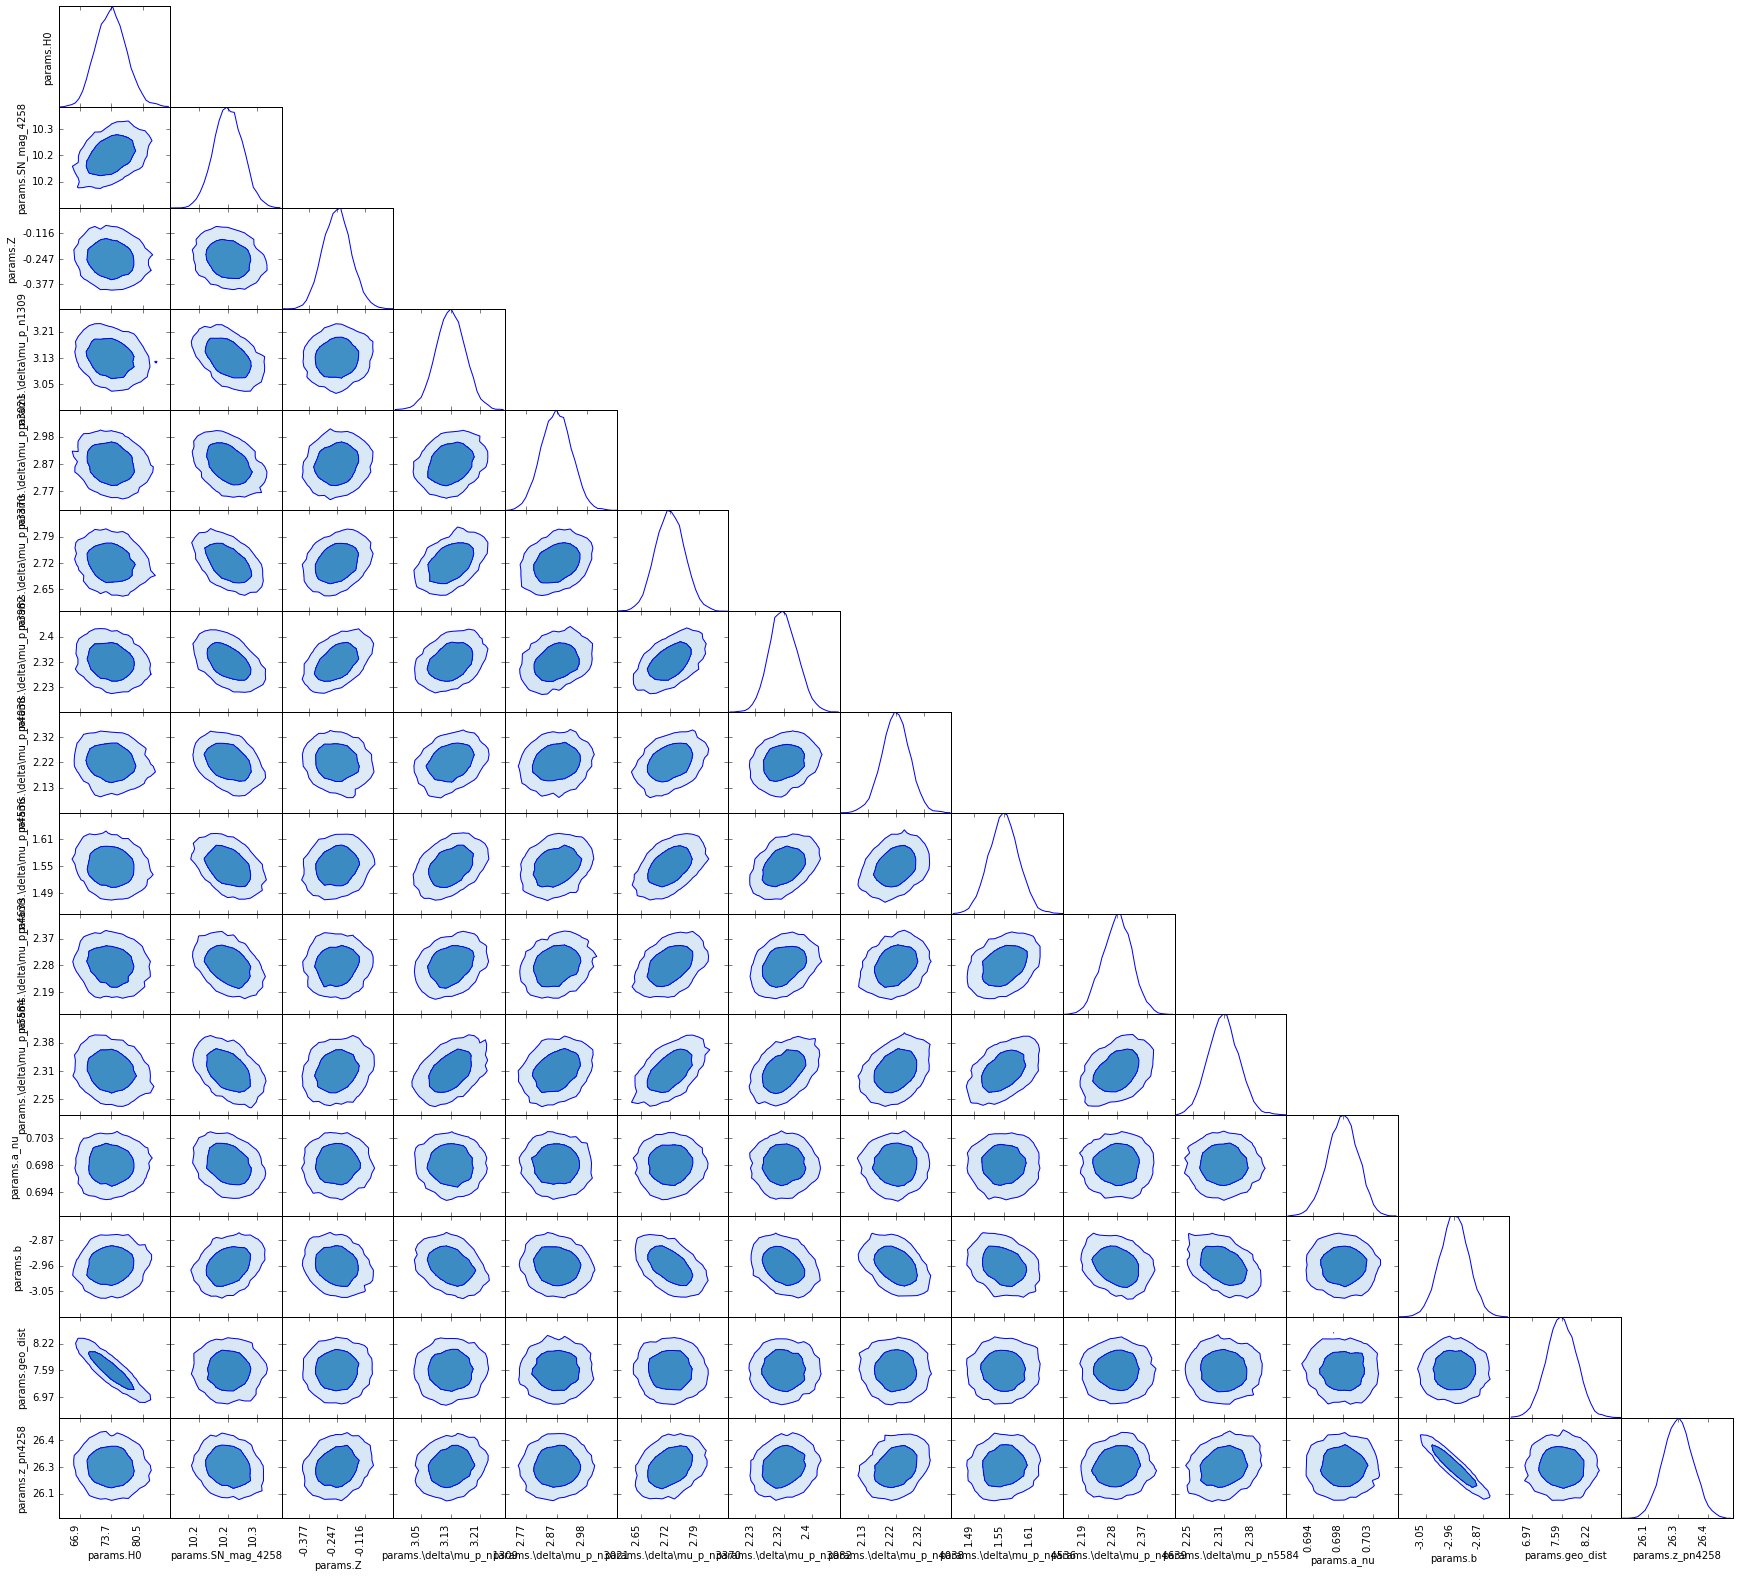

In [63]:
std_chain.likegrid()